# Gravitational Waves Example: CNN Embedding + Flow Matching

This notebook demonstrates an advanced Simulation-Based Inference (SBI) workflow for Gravitational Wave (GW) inference.

## Conceptual Overview

In standard NPE (Neural Posterior Estimation), we learn the posterior distribution $p(\theta | x)$ directly. However, when $x$ is high-dimensional (like a GW time series), feeding it directly into a density estimator (like a Normalizing Flow) can be inefficient.

**Strategy:**
1.  **Compression (VAE)**: We utilize the encoder from a **Variational Autoencoder (VAE)** architecture to compress the high-dimensional conditional data $x$ (time series) into a lower-dimensional latent representation $z$.
2.  **Inference (Flow Matching)**: We condition our inference model (a **Flux** Flow Matching model) on this latent representation $z$. The relationship is: $p(\theta | x) \approx p(\theta | z = E(x))$, where $E$ is the VAE encoder.

**Important Clarification:** Although we use the encoder from a VAE, **we are not actually training the entire VAE** (which would require training also the decoder). Training a full VAE (encoder + decoder) is only needed if one wants to perform sampling in the latent space of the observation (currently not yet supported). Here, the encoder is trained end-to-end with the flow matching model to optimize the inference objective.

This two-step approach allows the inference model to work with compact, semantic representations of the data.

## Configuration & Hyperparameters

We use the configuration from `gw_config_6c.yaml`. Here is a breakdown of the key parameters:

### Data Dimensions
- **Observation ($\theta$)**: 2 dimensions (Compact Binary Coalescence parameters).
- **Conditioning ($x$)**: 8192 time steps (1D signal).
- **Channels**: 2 input channels for the VAE (detectors), 1 channel for $\theta$.

### The Embedding Network (VAE)
This is a 1D Convolutional Autoencoder.
- **Resolution**: 8192
- **Input Channels**: 2
- **Base Channels (`ch`)**: 32
- **Channel Multipliers (`ch_mult`)**: `[1, 2, 4, 8, 16, 16, 16, 16]`
    - This defines the depth and downsampling. Each level increases the channel count and decreases the temporal resolution.
- **Latent Channels (`z_channels`)**: 128. The final compressed representation has 128 channels.

### The Inference Model (Flux)
A Flow Matching model based on a Transformer backbone.
- **Context Dimension (`context_in_dim`)**: 128. This MUST match the `z_channels` of the VAE, as the VAE's output is the Flux model's input context.
- **Depth**: 8 transformer blocks.
- **Heads**: 4 attention heads.


## 1. Setup and Imports

First, we set up the environment and import necessary libraries.

In [1]:
# Check if running on Colab and install dependencies if needed
try:
    import google.colab
    colab = True
except ImportError:
    colab = False

if colab:
    # Install required packages and clone the repository
    %pip install "gensbi[cuda12, examples] @ git+https://github.com/aurelio-amerio/GenSBI"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/sbi-benchmarks/gravitational_waves

In [1]:
import os
os.environ["JAX_PLATFORMS"] = "cpu"

# Set JAX to use CPU or GPU as appropriate
# if os.environ.get("JAX_PLATFORMS") is None:
#     # Default to CPU for safety in this example, or set to 'cuda' if GPU is available
#     os.environ["JAX_PLATFORMS"] = "cuda"
#     os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".90"

import gc
from datasets import load_dataset
import grain.python as grain # grain is used for data loading
import jax
from jax import numpy as jnp
from jax import Array
import yaml
import numpy as np
from flax import nnx
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

# GenSBI imports
from gensbi.experimental.models.autoencoders import (
    AutoEncoder1D,
    AutoEncoderParams,
)
from gensbi.experimental.recipes.vae_pipeline import parse_autoencoder_params
from gensbi.recipes.flux1 import parse_flux1_params, parse_training_config
from gensbi.utils.plotting import plot_marginals
from gensbi.models import Flux1Params, Flux1
from gensbi.recipes import ConditionalFlowPipeline

# Point to the config file
config_path = "./config/gw_config_6c_1.yaml"

/lhome/ific/a/aamerio/miniforge3/envs/gensbi/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at grain/proto/execution_summary.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


## 2. Helper Functions and Classes

We define normalization helpers and the wrapper class that connects the VAE and the SBI model.

In [2]:
def normalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return (batch - mean) / std

def unnormalize(batch, mean, std):
    mean = jnp.asarray(mean, dtype=batch.dtype)
    std = jnp.asarray(std, dtype=batch.dtype)
    return batch * std + mean

class GWModel(nnx.Module):
    """
    A combined model that first encodes the conditioning data (x) using a VAE,
    and then passes the latent embedding to the SBI model (Flux).
    """
    def __init__(self, vae, sbi_model):
        self.vae = vae
        self.sbi_model = sbi_model

    def __call__(
        self,
        t: Array,
        obs: Array,
        obs_ids: Array,
        cond: Array,
        cond_ids: Array,
        conditioned: bool | Array = True,
        guidance: Array | None = None,
        encoder_key=None,
    ):
        # 1. Encode the high-dimensional conditioning data `cond` (GW time series)
        # The VAE encoder reduces it to a latent feature map `cond_latent`
        cond_latent = self.vae.encode(cond, encoder_key)

        # 2. Pass the parameters `obs` (theta) and the encoded condition to the Flow model
        return self.sbi_model(
            t=t,
            obs=obs,
            obs_ids=obs_ids,
            cond=cond_latent, # The flow sees the compressed representation
            cond_ids=cond_ids,
            conditioned=conditioned,
            guidance=guidance,
        )

## 3. Data Loading

We load the Gravitational Waves dataset.

In [3]:
repo_name = "aurelio-amerio/SBI-benchmarks"
task_name = "gravitational_waves"

# Load dataset with numpy format
dataset = load_dataset(repo_name, task_name).with_format("numpy")

df_train = dataset["train"]
df_val = dataset["validation"]
df_test = dataset["test"]

# Define normalization statistics (pre-computed versions to save time vs computing on full dataset)
xs_mean = jnp.array([[[0.00051776, -0.00040733]]], dtype=jnp.bfloat16)
thetas_mean = jnp.array([[44.826576, 45.070328]], dtype=jnp.bfloat16)
xs_std = jnp.array([[[60.80799, 59.33193]]], dtype=jnp.bfloat16)
thetas_std = jnp.array([[20.189356, 20.16127]], dtype=jnp.bfloat16)

dim_obs = 2
ch_obs = 1
# Note: dim_cond and ch_cond are for the raw data, but the model will work on VAE latents.

Resolving data files:   0%|          | 0/18 [00:00<?, ?it/s]

In [ ]:
# plot one sample
idx = 0
x_o_raw = df_test["xs"][idx][None, ...]
theta_true = df_test["thetas"][idx]

# Normalize observation
x_o = normalize(jnp.array(x_o_raw, dtype=jnp.bfloat16), xs_mean, xs_std)

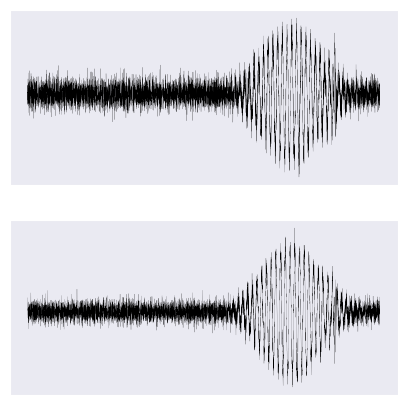

In [18]:
fig,axes = plt.subplots(2,1, figsize=(5,5))

axes[0].plot(x_o[0,:,0], lw=0.1, color="k")
axes[1].plot(x_o[0,:,1], lw=0.1, color="k")
# hide axes labels
axes[0].set_xticks([])
axes[0].set_yticks([])
axes[1].set_xticks([])
axes[1].set_yticks([])
plt.savefig("gw_example.png", dpi=300,bbox_inches="tight")
plt.show()

## 4. Model Initialization

We initialize the VAE and the Flux model using the configuration.

In [ ]:
# --- 1. Initialize VAE ---
params_dict = parse_autoencoder_params(config_path)

ae_params = AutoEncoderParams(
    rngs=nnx.Rngs(0),
    **params_dict,
)

vae_model = AutoEncoder1D(ae_params)

# Optimization: Remove the decoder since we only need the encoder for NPE
vae_model.Decoder1D = None
gc.collect()

# Get latent dimensions from the initialized VAE to configure the Flow model correctly
dim_cond_latent = vae_model.latent_shape[1]
z_ch = vae_model.latent_shape[2]
print(f"VAE Output Shape: (Length={dim_cond_latent}, Channels={z_ch})")

# --- 2. Initialize Flux (SBI Model) ---
params_dict_flux = parse_flux1_params(config_path)

# Ensure the Flux model expects the context dimension provided by the VAE
params_flux = Flux1Params(
    rngs=nnx.Rngs(0),
    dim_obs=dim_obs,
    dim_cond=dim_cond_latent, 
    **params_dict_flux,
)

model_sbi = Flux1(params_flux)

# --- 3. Combine them ---
model = GWModel(vae_model, model_sbi)

## 5. Pipeline and Restoration

We set up the `ConditionalFlowPipeline`. Instead of training, we will restore a pre-trained checkpoint.

In [ ]:
# Pre-processing map for the dataset pipeline
def split_data(batch):
    obs = jnp.array(batch["thetas"], dtype=jnp.bfloat16)
    obs = normalize(obs, thetas_mean, thetas_std)
    obs = obs.reshape(obs.shape[0], dim_obs, ch_obs)
    cond = jnp.array(batch["xs"], dtype=jnp.bfloat16)
    cond = normalize(cond, xs_mean, xs_std)
    return obs, cond

# Training stats needed for pipeline init (even for inference)
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
    batch_size = config["training"]["batch_size"]
    training_config = parse_training_config(config_path)

# Dummy dataset creation for pipeline initialization
# (The pipeline uses this to infer shapes and types, even if we just restore)
train_dataset_npe = (
    grain.MapDataset.source(df_train)
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(batch_size)
    .map(split_data)
)
val_dataset_npe = (
    grain.MapDataset.source(df_val)
    .shuffle(42)
    .repeat()
    .to_iter_dataset()
    .batch(512)
    .map(split_data)
)

# Set checkpoint directory
training_config["checkpoint_dir"] = (
    "/lhome/ific/a/aamerio/data/github/GenSBI-examples/examples/sbi-benchmarks/gravitational_waves/gw_npe_v6c/checkpoints"
)

# the ConditionalFlowPipeline supports an arbitrary model (with the right interface), 
# so we can pass it our composite model
pipeline_latent = ConditionalFlowPipeline(
    model,
    train_dataset_npe,
    val_dataset_npe,
    dim_obs=dim_obs,
    dim_cond=dim_cond_latent,  # Latent length
    ch_obs=ch_obs,
    ch_cond=z_ch,  # Latent channels
    training_config=training_config,
)

print("Restoring model from checkpoint...")
pipeline_latent.restore_model()
print("Model restored!")

## 6. Inference and Visualization

We take a single observation from the test set, sample the posterior using our model, and visualize the results.

In [ ]:
# 1. Select a test observation
idx = 0
x_o_raw = df_test["xs"][idx][None, ...]
theta_true = df_test["thetas"][idx]

# Normalize observation
x_o = normalize(jnp.array(x_o_raw, dtype=jnp.bfloat16), xs_mean, xs_std)

# 2. Sample from the posterior
# We generate 100,000 samples to get a smooth distribution
print("Sampling...")
samples = pipeline_latent.sample_batched(
    nnx.Rngs(0).sample(),
    x_o,
    100_000,
    chunk_size=10_000,
    encoder_key=jax.random.PRNGKey(1234),
)

# Reshape samples: (num_samples, 1, 2, 1) -> (num_samples, 2)
res = samples[:, 0, :, 0]

# 3. Unnormalize to get back to physical units
res_unnorm = unnormalize(res, thetas_mean, thetas_std)

# Apply modulo 360 as these are periodic angular parameters
res_unnorm = jnp.mod(res_unnorm, 360.0)


In [ ]:
# 4. Plot
print("Plotting marginals...")
plot_marginals(
    res_unnorm, 
    true_param=theta_true, 
    range=[(25, 75), (25, 75)], # Zoom in on the relevant region
    gridsize=30
)
plt.show()